# London POI Data Preparation

POI data is from Foursquare.

## 1. Import Libraries

In [12]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
import seaborn as sns
import re
import matplotlib.font_manager as fm

## 2. Load POI Data

In [37]:
# Read in unclipped London POI data
fs_london_unclipped = gpd.read_file("../../data/london/fs_london.csv")

# Import Greater London glx towns
glondon_seamless = gpd.read_file("../../data/london/glondon_seamless.gpkg")
# Set CRS
glondon_seamless.crs = "EPSG:4326"

## 3. Data Cleaning

In [38]:
# Remove square brackets from the category label strings
category_strings = fs_london_unclipped['fsq_category_labels'].str.strip('[]')

# Replace commas with ' > ' to indicate category hierarchy
category_strings = category_strings.str.replace(r'\s*,\s*', ' > ', regex=True)

# Replace empty strings with NaN
category_strings = category_strings.replace('', np.nan)

# Split the hierarchy into separate columns (one per level)
categories_df = category_strings.str.split(' > ', expand=True)

# Ensure there are exactly 15 columns (pad with NaNs if fewer)
required_columns = list(range(15))
categories_df = categories_df.reindex(columns=required_columns)

# Rename columns to level1_category, level2_category, ..., level15_category
new_column_names = {i: f'level{i+1}_category' for i in range(15)}
categories_df = categories_df.rename(columns=new_column_names)

# Concatenate the new category levels back to the original dataframe
fs_london_unclipped = pd.concat([fs_london_unclipped, categories_df], axis=1)

In [39]:
# Keep only the columnes needed
fs_london_unclipped = fs_london_unclipped[["fsq_place_id", "name", "post_town", "fsq_category_labels", "latitude", "longitude", "address", "level1_category", "level2_category", "level3_category", "level4_category", "level5_category", "level6_category", "level7_category", "level8_category", "level9_category", "level10_category", "level11_category", "level12_category", "level13_category", "level14_category", "level15_category"]]

In [40]:
# Convert to geoDF
fs_london_unclipped["geometry"] = gpd.points_from_xy(fs_london_unclipped["longitude"], fs_london_unclipped["latitude"])
fs_london_unclipped = gpd.GeoDataFrame(fs_london_unclipped, geometry="geometry")

# Set CRS
fs_london_unclipped.crs = "EPSG:4326"

In [41]:
# Clip POIs to London boundary
fs_london_clipped = gpd.sjoin(fs_london_unclipped, glondon_seamless, predicate = "within")

## 4. Data Exploration

/var/folders/1n/_7fnqrv504n3tlnbg2hqgkdh0000gn/T/ipykernel_23406/2594035154.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(


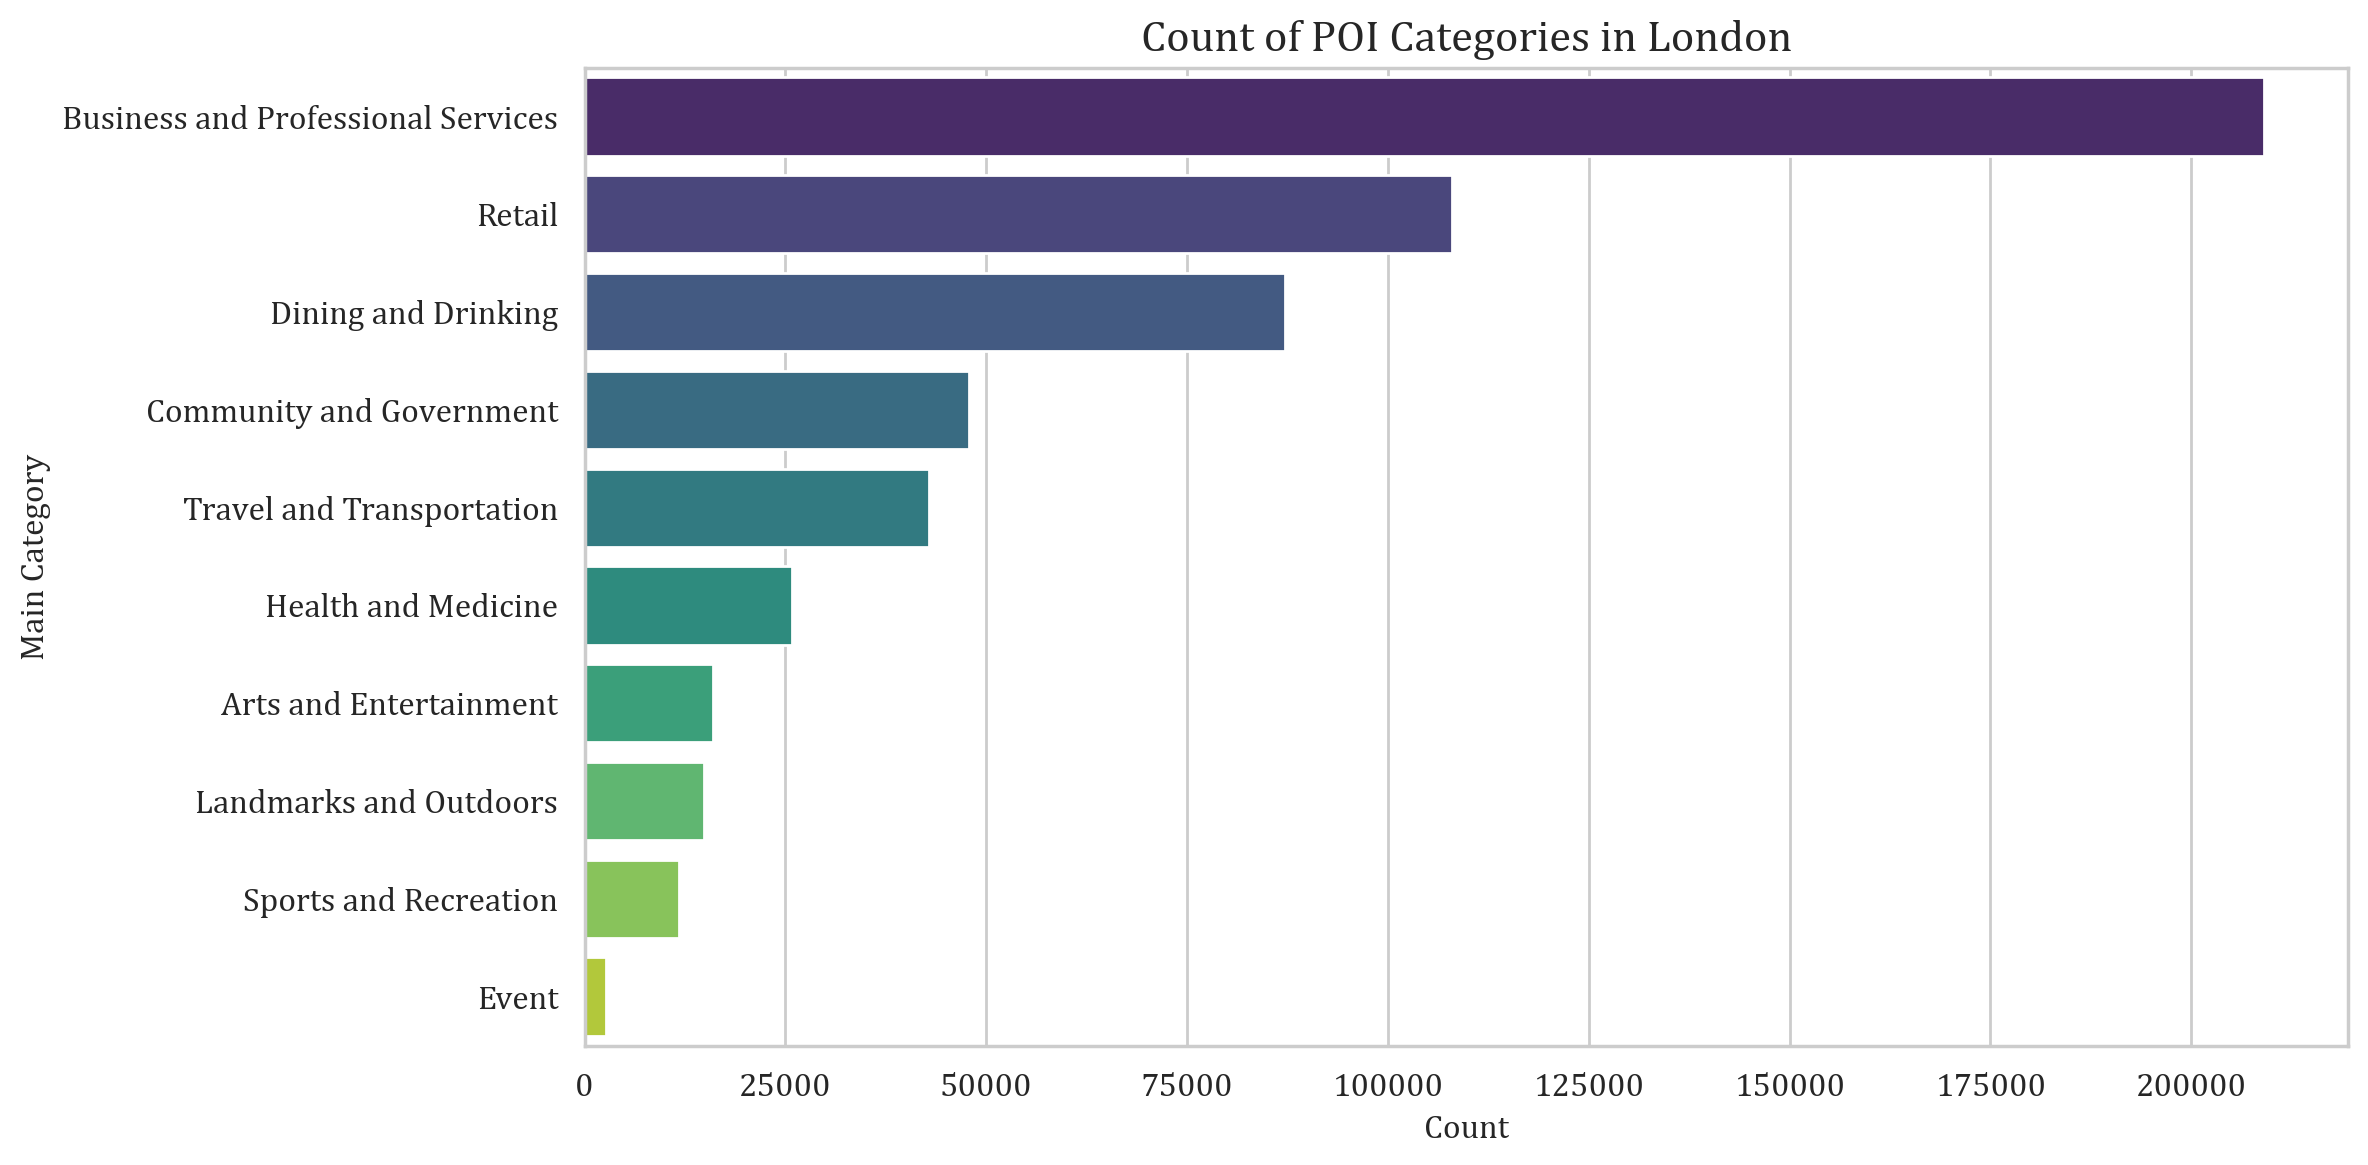

In [42]:
# Load custom font
cambria_path = "/Library/Fonts/Microsoft/Cambria.ttf" 
cambria_prop = fm.FontProperties(fname=cambria_path)

# Create the plot
#sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
ax = sns.countplot(
    data=fs_london_clipped,
    y="level1_category",
    order=fs_london_clipped["level1_category"].value_counts().index,
    palette="viridis"
)

# Set custom font on each text element
plt.title("Count of POI Categories in London", fontproperties=cambria_prop, fontsize=16)
plt.xlabel("Count", fontproperties=cambria_prop, fontsize=12)
plt.ylabel("Main Category", fontproperties=cambria_prop, fontsize=12)

# Update tick labels to use the font
for label in ax.get_xticklabels():
    label.set_fontproperties(cambria_prop)
for label in ax.get_yticklabels():
    label.set_fontproperties(cambria_prop)

plt.tight_layout()
plt.show()

## 5. Aggregate POIs to Towns

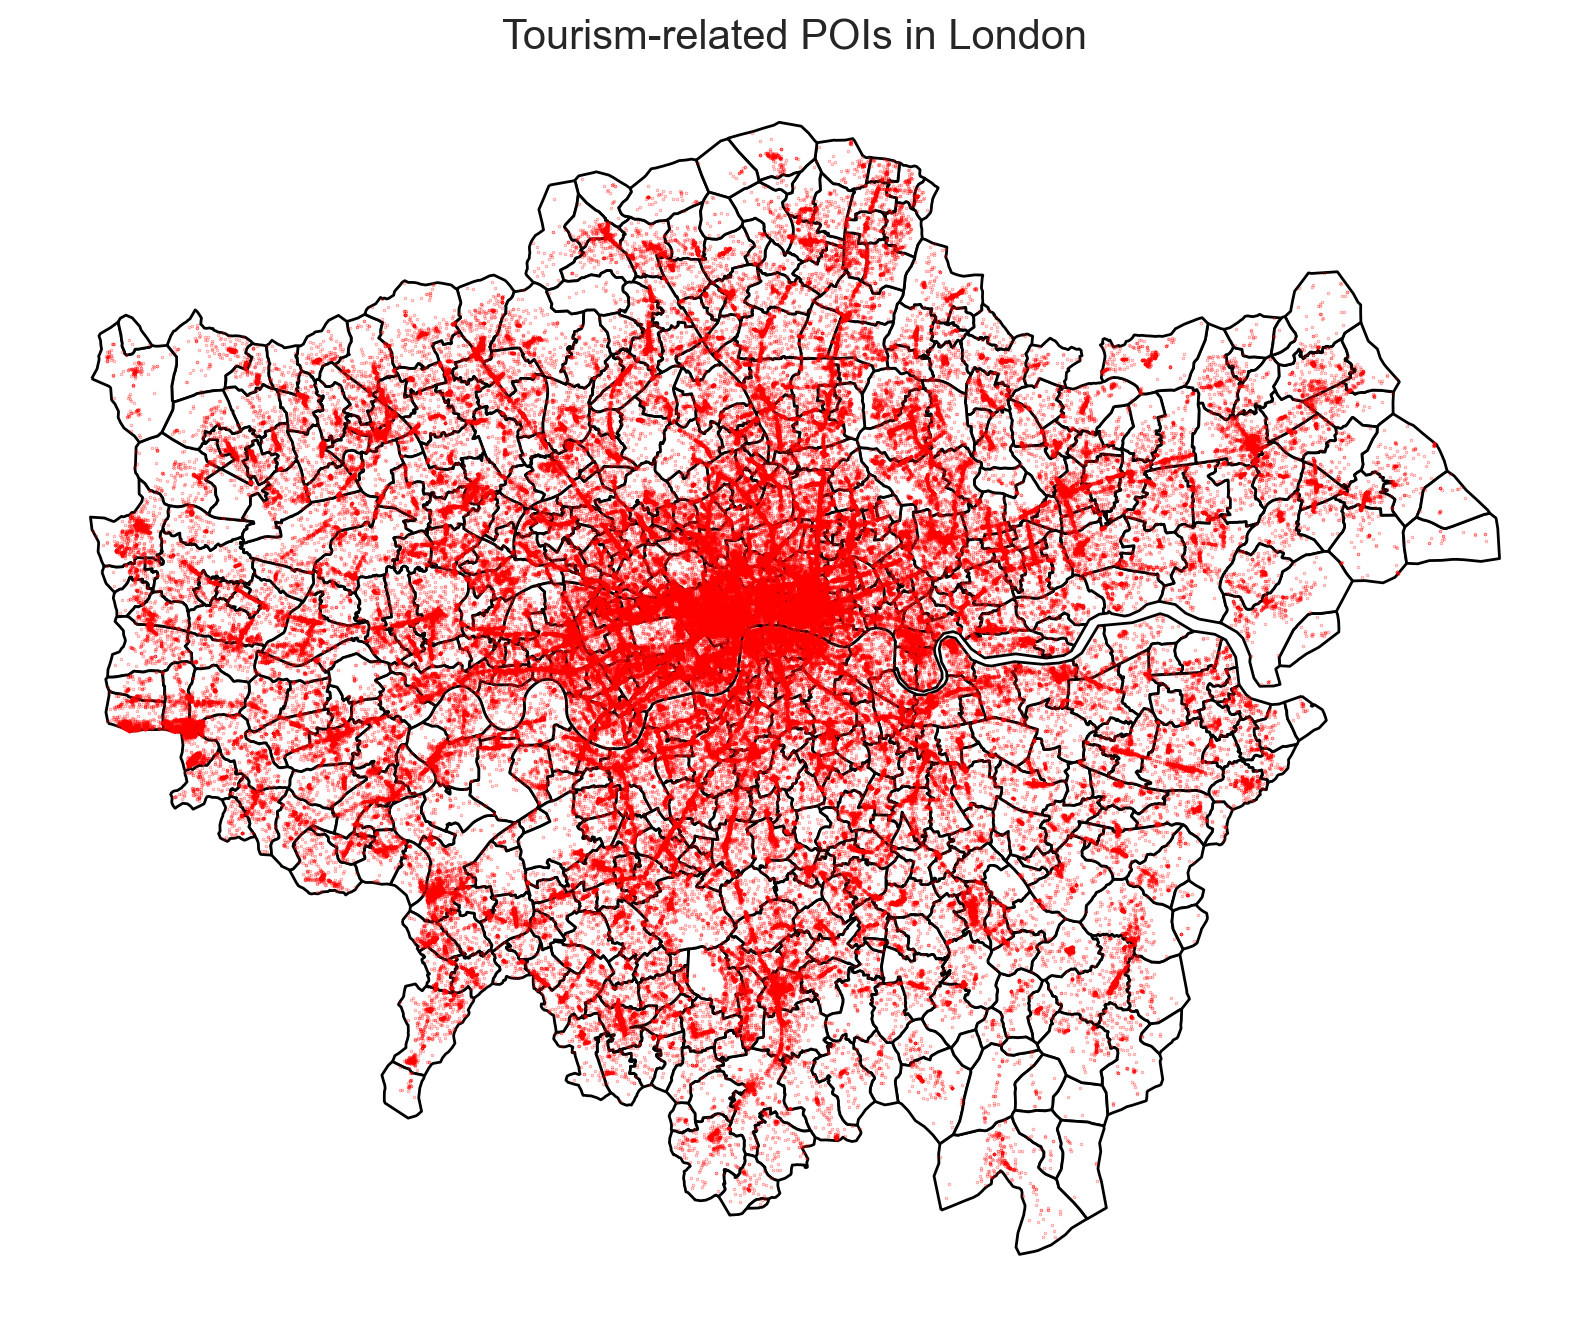

In [29]:
# Plot town boundaries
ax = glondon_seamless.plot(figsize = (10,10), color = "white", edgecolor="black")
# Plot poi points
london_tourism_pois.plot(ax = ax, color = "red", markersize = 0.05, alpha = 0.5)

ax.set_title("Tourism-related POIs in London", fontsize = 15)
ax.set_axis_off()

In [43]:
# Drop sjoin artifacts if they exist
for df in [fs_london_clipped, glondon_seamless]:
    if 'index_right' in df.columns:
        df.drop(columns = 'index_right', inplace = True)

# Count POIs per area and category
glondon_fs_cat_count = (
    fs_london_clipped.groupby(['id', 'level1_category'])
    .size()
    .reset_index(name = 'count')
)

# Pivot to wide format
glondon_fs_cat_count_pivot = glondon_fs_cat_count.pivot_table(
    index = 'id',
    columns = 'level1_category',
    values = 'count',
    fill_value=0
).reset_index()

# Merge counts with geometry
fs_london_counts = glondon_seamless.merge(glondon_fs_cat_count_pivot, on = 'id', how = 'left')
fs_london_counts.fillna(0, inplace = True)

# Calculate total POIs per area
fs_london_counts_cols = glondon_fs_cat_count_pivot.columns.difference(['id'])
fs_london_counts['total_pois'] = fs_london_counts[fs_london_counts_cols].sum(axis = 1)

# Calculate proportions
for col in fs_london_counts_cols:
    fs_london_counts[f'{col}_count'] = fs_london_counts[col]
    fs_london_counts[f'{col}_proportion'] = fs_london_counts[col] / fs_london_counts['total_pois'].replace(0, pd.NA)

# Reproject to British National Grid for accurate area calculation
fs_london_counts = fs_london_counts.to_crs(epsg=27700)

# Calculate area and density
fs_london_counts['area_km2'] = fs_london_counts.geometry.area / 1e6

for col in fs_london_counts_cols:
    fs_london_counts[f'{col}_density'] = fs_london_counts[col] / fs_london_counts['area_km2'].replace(0, pd.NA)

# Drop raw category cols
fs_london_counts.drop(columns = fs_london_counts_cols, inplace = True)

# Get log values for all columns
# Identify all count, proprotion, and density columns
fs_log_targets = [col for col in fs_london_counts.columns if col.endswith(('_count', '_proportion', '_density'))]

# Log-transform
for col in fs_log_targets:
    log_col = f'{col}_log'
    fs_london_counts[log_col] = np.log1p(pd.to_numeric(fs_london_counts[col], errors='coerce').fillna(0))

/var/folders/1n/_7fnqrv504n3tlnbg2hqgkdh0000gn/T/ipykernel_23406/1506935054.py:23: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  fs_london_counts.fillna(0, inplace = True)


In [44]:
# Identify the first 10 * _count_log columns
fs_london_count_log_cols = [col for col in fs_london_counts if col.endswith('_count_log')][:10]
# Identify the first 10 * _density_log columns
fs_london_density_log_cols = [col for col in fs_london_counts.columns if col.endswith('_density_log')][:10]
# Identify the first 10 * _proportion_log columns
fs_london_proportion_log_cols = [col for col in fs_london_counts.columns if col.endswith('_proportion_log')][:10]

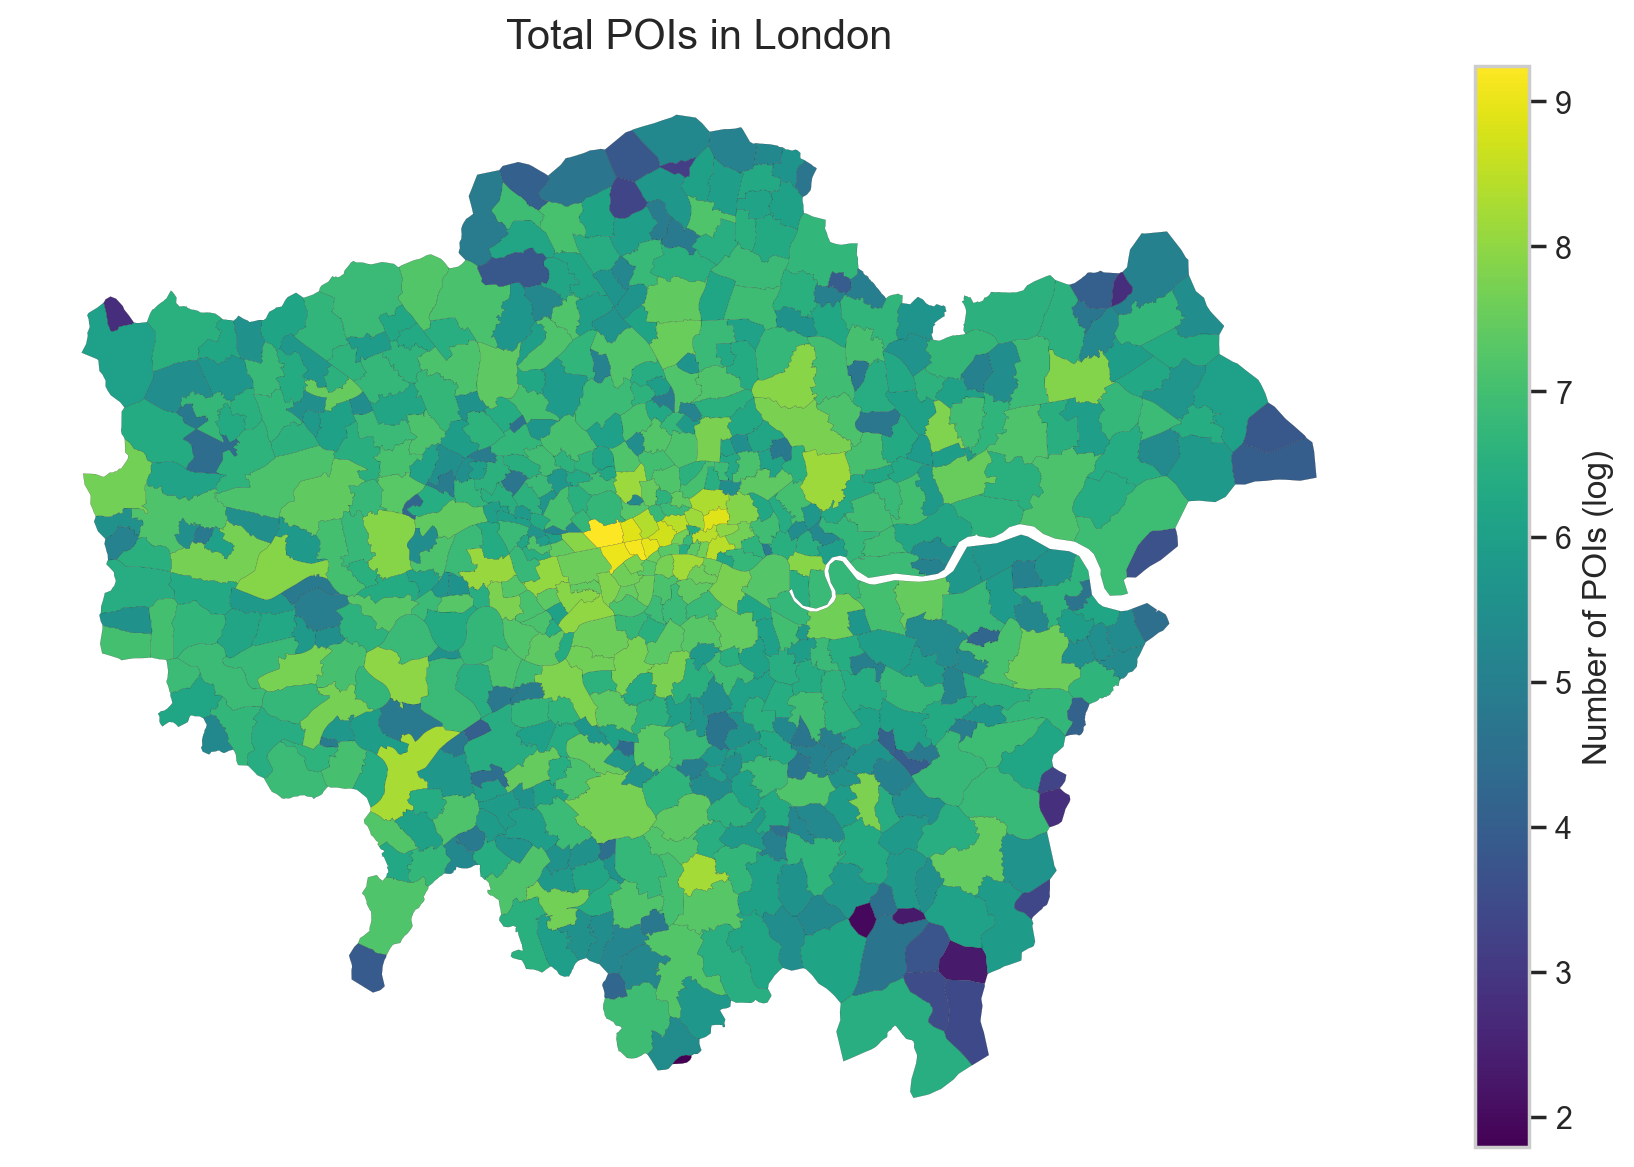

In [48]:
# log the total_pois column
fs_london_counts['total_pois_log'] = np.log1p(fs_london_counts['total_pois']+1)

# ---- Create graph for all POIs ----
fig, ax = plt.subplots(figsize=(10, 6))

fs_london_counts.plot(
    column='total_pois_log',
    cmap='viridis',
    legend=True,
    ax=ax,
    edgecolor='black',
    linewidth=0.05,
    legend_kwds={'label': "Number of POIs (log)", 'orientation': "vertical"}
)
ax.set_title("Total POIs in London", fontsize=15)
ax.set_axis_off()
plt.tight_layout()
plt.show()

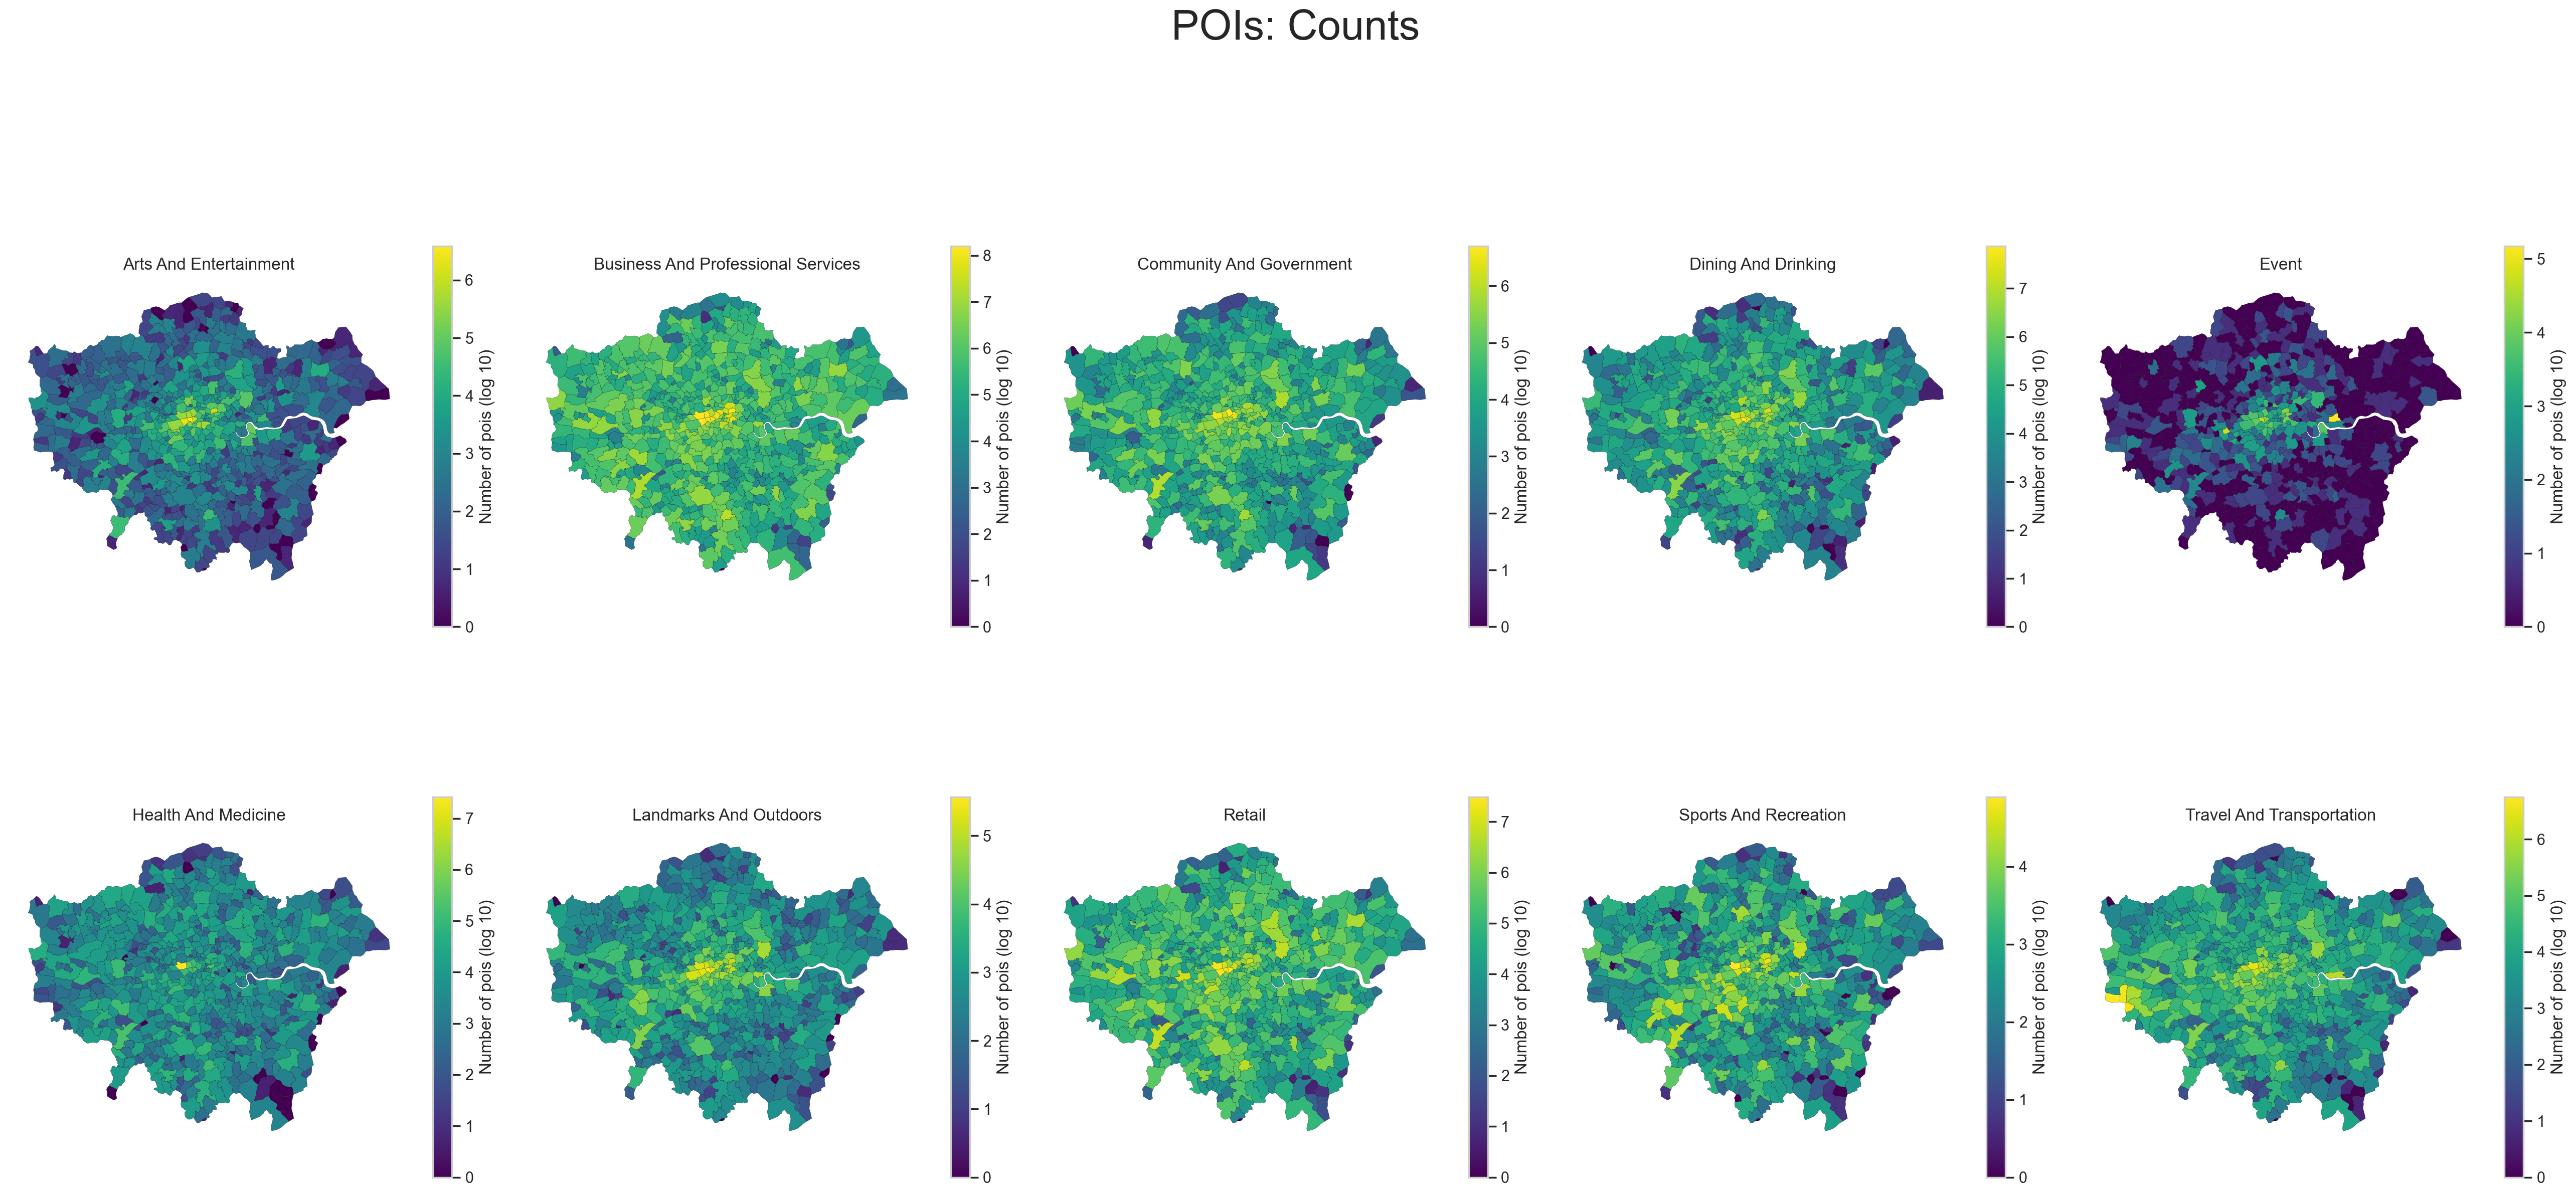

In [50]:
# ---- Create logged counts graph ----
# Create subplots (2 rows x 5 columns)
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(26, 14))
axes = axes.flatten()

# Plot each category
for ax, col in zip(axes, fs_london_count_log_cols):
    fs_london_counts.plot(
        column=col,
        cmap='viridis',
        legend=True,
        edgecolor='black',
        linewidth=0.1,
        ax=ax,
        legend_kwds={"shrink": 0.5, "label": 'Number of pois (log 10)'},
    )
    ax.set_title(col.replace('_count_log', '').replace('_', ' ').title())
    ax.set_axis_off()

plt.suptitle("POIs: Counts", fontsize = 30)
plt.tight_layout()
plt.show()

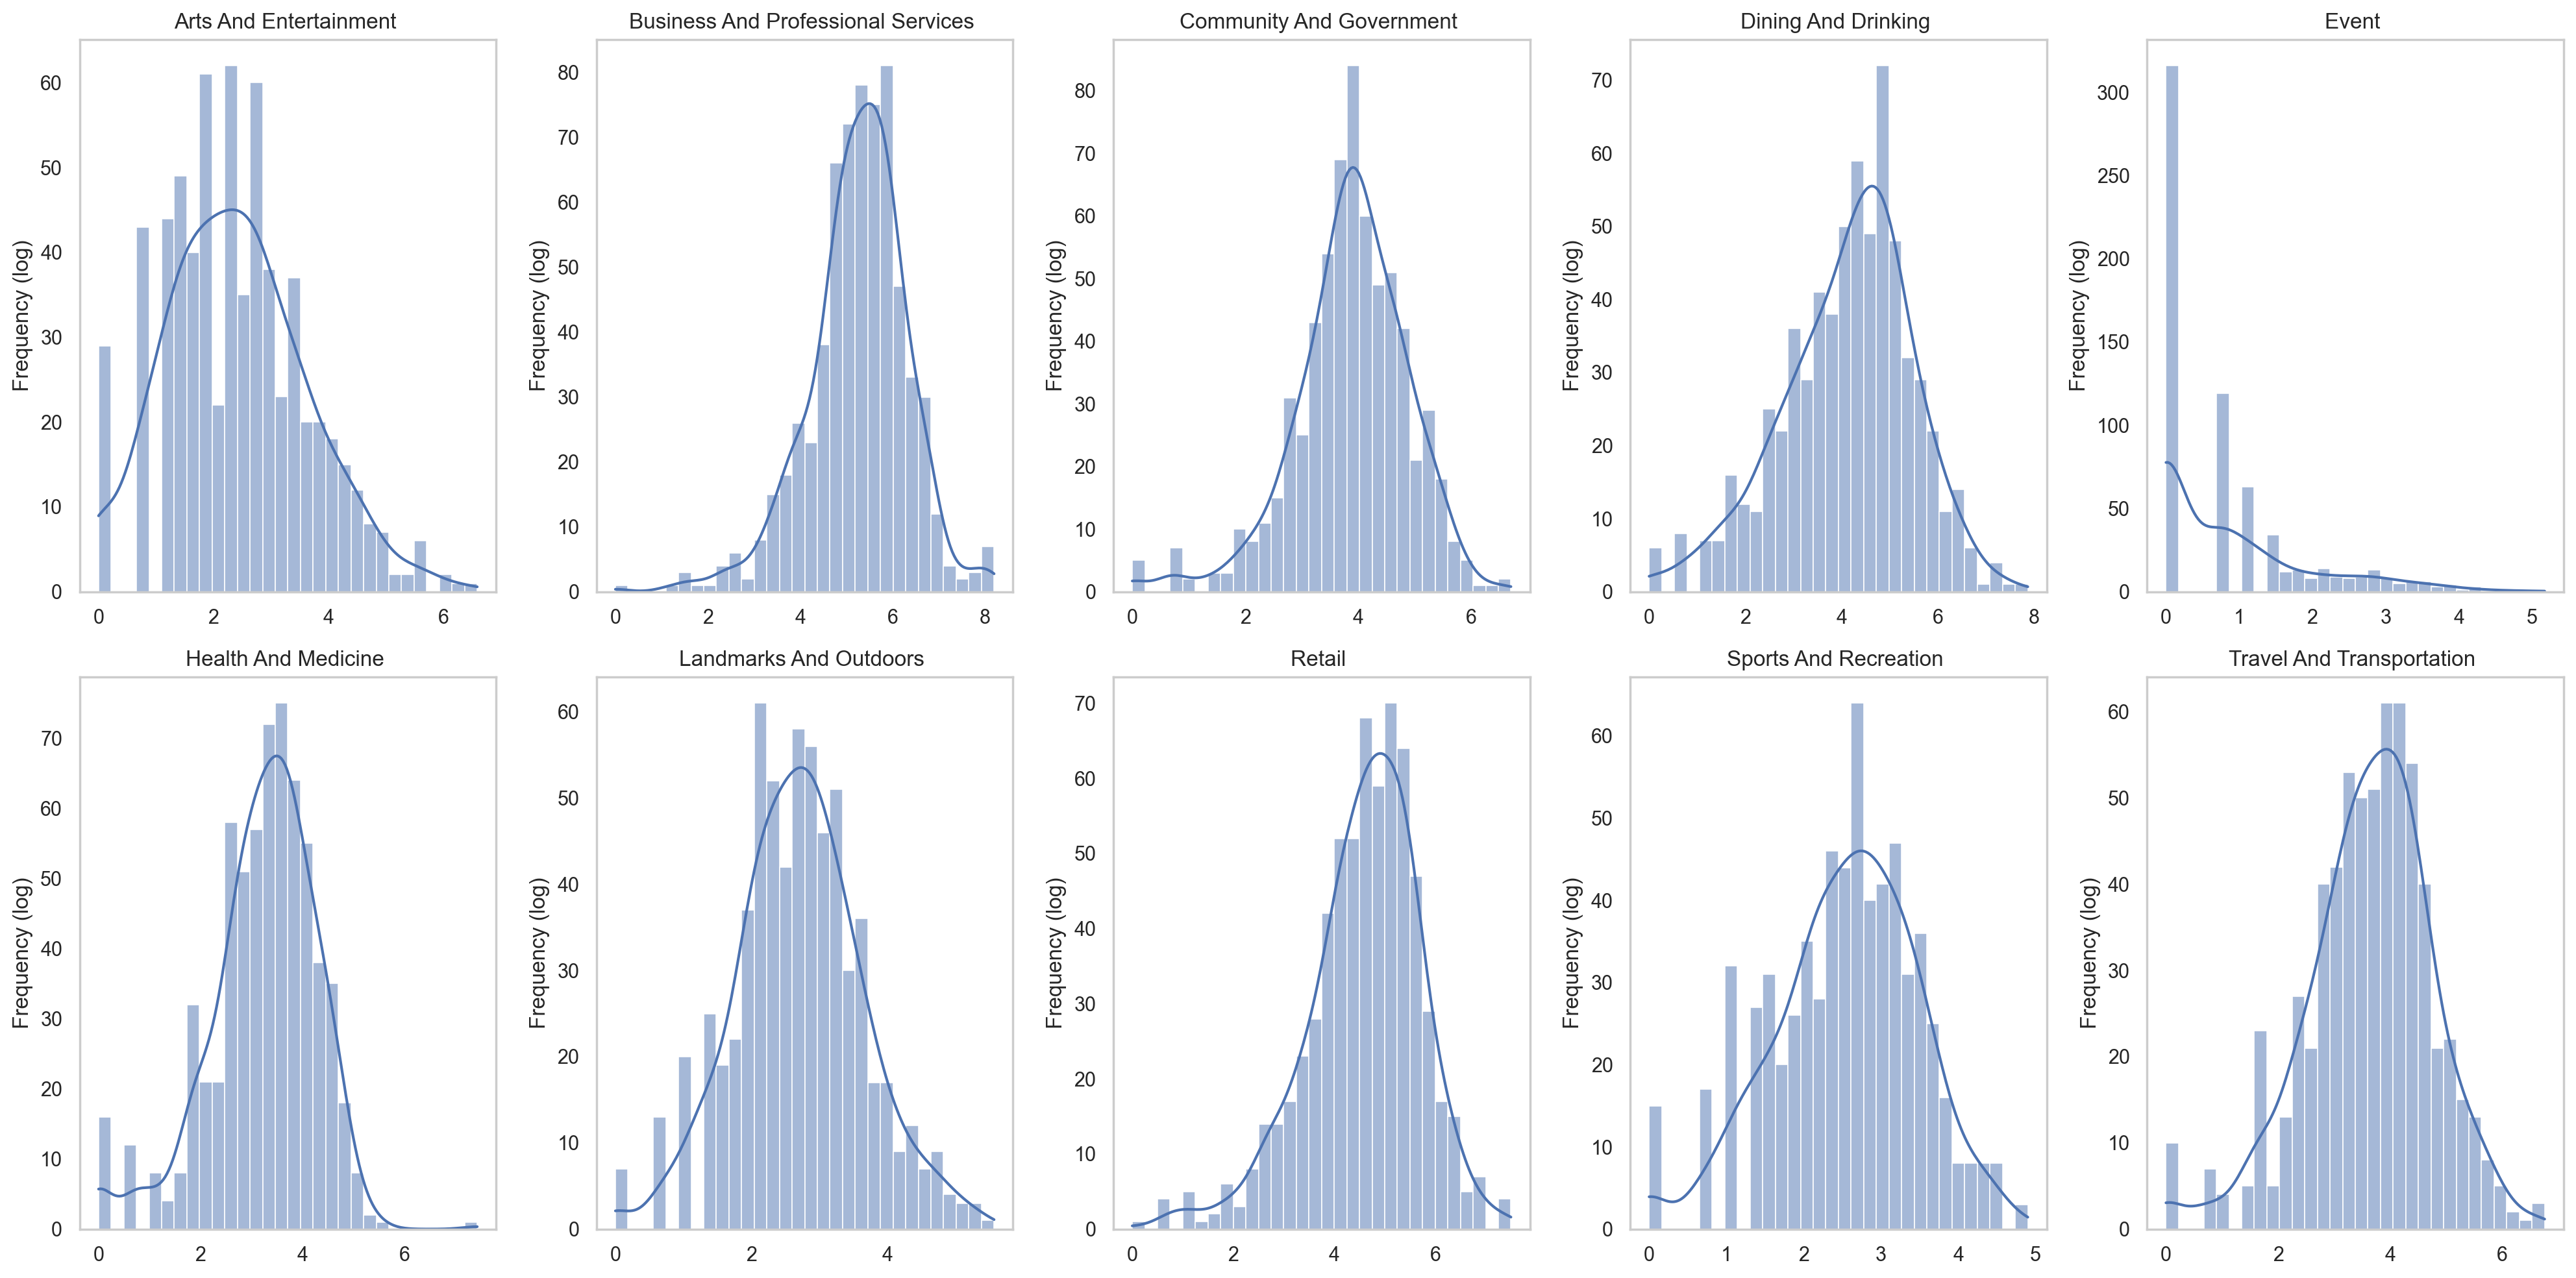

In [51]:
import seaborn as sns

## Histograms
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20,10))
axes = axes.flatten()

for i, col in enumerate(fs_london_count_log_cols):
    sns.histplot(
        data = fs_london_counts,
        x = col,
        ax = axes[i],
        kde = True,
        color = '#4c72b0',
        edgecolor = 'white',
        bins = 30
    )
    axes[i].set_title(col.replace("_count_log", " ").replace('_', ' ').title())
    axes[i].set_xlabel("")
    axes[i].set_ylabel("Frequency (log)")
    axes[i].grid(False)

plt.tight_layout()
plt.show()

## 6. Refining Tourism-related POI Categories

In [52]:
tourism_categories = [
    "Arts and Entertainment", 
    "Dining and Drinking", 
    "Landmarks and Outdoors",
    "Retail",
    "Travel and Transportation",
    "id"
]

# Keep only tourism categories and others
london_tourism_pois = fs_london_clipped[fs_london_clipped["level1_category"].isin(tourism_categories)]

In [53]:
# Only keep relevant columns
london_tourism_pois = london_tourism_pois[[
    "fsq_place_id", "name", "post_town", 
    "latitude", "longitude", "address",
    "level1_category", "level2_category", "level3_category",
    "level4_category", "level5_category", "level6_category",
    "level7_category", "level8_category", "level9_category",
    "level10_category", "level11_category", "level12_category",
    "level13_category", "level14_category", "level15_category",
    "id",
    "geometry"
]]

### Create Unified Search Column

In [54]:
# Select all the category level columns that exist
level_cols = [f'level{i}_category' for i in range(1, 16)]
existing_level_cols = [col for col in level_cols if col in london_tourism_pois.columns]

# Also include the name and fsq_category_labels
search_cols = ['name'] + existing_level_cols

# Fill amy missing values (NaN) with empty strings
london_tourism_pois[search_cols] = london_tourism_pois[search_cols].fillna('')

# Join them all into a single, lowercase string
london_tourism_pois['search_corpus'] = london_tourism_pois[search_cols].apply(lambda row: ' '.join(row).lower(), axis=1)

london_tourism_pois['search_corpus'].head().tolist()

['the quick landmarks and outdoors campground             ',
 'kiddicare retail miscellaneous store             ',
 'blooms the florist retail flower store             ',
 'city roofing contracts retail construction supplies store             ',
 'phones 4u retail computers and electronics retail mobile phone store            ']

### Dining and Drinking

In [75]:
# Filter the dataframe to only include 'Dining & Drinking' POIs
dining_df = london_tourism_pois[london_tourism_pois['level1_category'] == 'Dining and Drinking'].copy()

# Get all the unique sub-categories from Level 2 and Level 3 for dining
unique_level2_dining = dining_df['level2_category'].unique().tolist()
unique_level3_dining = dining_df['level3_category'].unique().tolist()

# Print them out in a clean format
print("--- Unique Level 2 Dining Categories ---")
print(unique_level2_dining)
print("\n" + "="*40 + "\n") # Separator
print("--- Unique Level 3 Dining Categories ---")
print(unique_level3_dining)

--- Unique Level 2 Dining Categories ---
['Restaurant', 'Cafe', 'Bakery', 'Dessert Shop', 'Breakfast Spot', 'Bar', 'Bagel Shop', 'Snack Place', 'Creperie', '', 'Juice Bar', 'Food Court', 'Donut Shop', 'Food Truck', 'Smoothie Shop', 'Cafeteria', 'Brewery', 'Retail', 'Food Stand', 'Distillery', 'Vineyard', 'Winery', 'Night Market', 'Meadery', 'Cidery', 'Health and Medicine']


--- Unique Level 3 Dining Categories ---
['Fish and Chips Shop', 'Coffee', '', 'Sandwich Spot', 'Indian Restaurant', 'Fast Food Restaurant', 'Dining and Drinking', 'Vegan and Vegetarian Restaurant', 'Kebab Restaurant', 'Fried Chicken Joint', 'Asian Restaurant', 'Pie Shop', 'Mediterranean Restaurant', 'Italian Restaurant', 'Pizzeria', 'Burger Joint', 'Wine Bar', 'Greek Restaurant', 'Spanish Restaurant', 'Pub', 'Theme Restaurant', 'Lounge', 'Deli', 'Cocktail Bar', 'Retail', 'Turkish Restaurant', 'BBQ Joint', 'Ice Cream Parlor', 'English Restaurant', 'Steakhouse', 'Caribbean Restaurant', 'Modern European Restaurant', 

In [76]:
def classify_dining(row):
    """
    Classifies a Dining & Drinking POI into a refined category based on its
    Foursquare category labels and name, using regex-based phrase matching.
    """
    search_string = row['search_corpus']

    # --- Tier 1: High-Value & Specialty Venues ---
    if re.search(r'\bmichelin\b', search_string) or re.search(r'\bfine dining\b', search_string) or re.search(r'\bmolecular gastronomy\b', search_string):
        return 'Fine Dining'
    if re.search(r'\bcocktail bar\b', search_string) or re.search(r'\bspeakeasy\b', search_string) or \
       re.search(r'\brooftop bar\b', search_string) or re.search(r'\bwhisky bar\b', search_string) or \
       re.search(r'\bwine bar\b', search_string):
        return 'Specialty Bar'
    if re.search(r'\bnightclub\b', search_string) or re.search(r'\bkaraoke bar\b', search_string) or \
       re.search(r'\bgay bar\b', search_string) or re.search(r'\bpiano bar\b', search_string):
        return 'Nightlife/Late Bar'

    # --- Tier 2: Core Establishment Types ---
    if re.search(r'\bpub\b', search_string) or re.search(r'\bgastropub\b', search_string) or re.search(r'\birish pub\b', search_string):
        return 'Pub'
    if re.search(r'\bbeer garden\b', search_string) or re.search(r'\bbeer bar\b', search_string):
        return 'Beer Bar/Garden'
    if re.search(r'\bbar\b', search_string) or re.search(r'\blounge\b', search_string) or \
       re.search(r'\bhotel bar\b', search_string) or re.search(r'\bsports bar\b', search_string):
        return 'Bar (General)'
    if re.search(r'\bcafe\b', search_string) or re.search(r'\bcoffee\b', search_string) or re.search(r'\bcreperie\b', search_string):
        return 'Cafe/Coffee Shop'
    if re.search(r'\bbakery\b', search_string) or re.search(r'\bpastry shop\b', search_string) or \
       re.search(r'\bcupcake shop\b', search_string) or re.search(r'\bdonut shop\b', search_string):
        return 'Bakery/Patisserie'
    if re.search(r'\bdessert shop\b', search_string) or re.search(r'\bice cream parlor\b', search_string) or \
       re.search(r'\bgelato shop\b', search_string) or re.search(r'\bfrozen yogurt\b', search_string) or \
       re.search(r'\bwaffle shop\b', search_string):
        return 'Dessert Shop'

    # --- Tier 3: Quick Service & Casual Dining ---
    if any(re.search(rf'\b{k}\b', search_string) for k in [
        'fast food', 'fried chicken', 'kebab', 'burger joint', 'sandwich spot',
        'pie shop', 'hot dog', 'wings joint', 'falafel'
    ]):
        return 'Quick Service Restaurant (QSR)'
    if re.search(r'\bpizzeria\b', search_string):
        return 'Pizzeria'
    if re.search(r'\bfood truck\b', search_string) or re.search(r'\bfood stand\b', search_string) or re.search(r'\bsnack place\b', search_string):
        return 'Food Truck/Stand'

    # --- Tier 4: Sit-Down Restaurants (by Cuisine) ---
    if any(re.search(rf'\b{k}\b', search_string) for k in [
        'italian', 'french', 'spanish', 'greek', 'portuguese', 'english',
        'modern european', 'eastern european', 'polish', 'german',
        'scandinavian', 'scottish'
    ]):
        return 'Restaurant (European)'
    if any(re.search(rf'\b{k}\b', search_string) for k in [
        'asian', 'indian', 'pakistani', 'bangladeshi', 'sri lankan',
        'afghan', 'halal', 'dumpling', 'seafood'
    ]):
        return 'Restaurant (Asian/South Asian)'
    if any(re.search(rf'\b{k}\b', search_string) for k in [
        'middle eastern', 'turkish', 'mediterranean', 'moroccan'
    ]):
        return 'Restaurant (Middle Eastern)'
    if any(re.search(rf'\b{k}\b', search_string) for k in [
        'american', 'mexican', 'latin american', 'caribbean', 'southern food'
    ]):
        return 'Restaurant (Americas)'
    if re.search(r'\bafrican\b', search_string):
        return 'Restaurant (African)'
    if re.search(r'\bvegan\b', search_string) or re.search(r'\bvegetarian\b', search_string):
        return 'Restaurant (Vegan/Vegetarian)'
    if re.search(r'\brestaurant\b', search_string):
        return 'Restaurant (Other)'

    # --- Tier 5: Food Production ---
    if any(re.search(rf'\b{k}\b', search_string) for k in ['brewery', 'distillery', 'winery', 'vineyard', 'cidery']):
        return 'Brewery/Distillery'

    # --- Tier 6: Other ---
    if re.search(r'\bjuice bar\b', search_string) or re.search(r'\bsmoothie shop\b', search_string):
        return 'Juice/Smoothie Bar'
    if re.search(r'\bfood court\b', search_string) or re.search(r'\bcafeteria\b', search_string):
        return 'Food Court/Cafeteria'

    return 'Dining (Other)'

In [77]:
# Create a mask for the 'Dining & Drinking' category
dining_mask = london_tourism_pois['level1_category'] == 'Dining and Drinking'

# Apply the function to the dining rows
london_tourism_pois.loc[dining_mask, 'refined_category'] = london_tourism_pois[dining_mask].apply(classify_dining, axis=1)

In [78]:
# See the breakdown of your new dining categories
print(london_tourism_pois[dining_mask]['refined_category'].value_counts())

refined_category
Cafe/Coffee Shop                  17706
Restaurant (Asian/South Asian)    12049
Quick Service Restaurant (QSR)     9483
Bar (General)                      9414
Restaurant (Other)                 7519
Restaurant (European)              5663
Pub                                4762
Bakery/Patisserie                  3511
Specialty Bar                      3285
Restaurant (Middle Eastern)        2554
Pizzeria                           2430
Restaurant (Americas)              2418
Food Truck/Stand                   1659
Dessert Shop                       1305
Dining (Other)                      882
Beer Bar/Garden                     562
Nightlife/Late Bar                  478
Restaurant (African)                420
Brewery/Distillery                  359
Restaurant (Vegan/Vegetarian)       351
Food Court/Cafeteria                276
Fine Dining                          26
Juice/Smoothie Bar                   23
Name: count, dtype: int64


In [79]:
# Sum all restaurants to a "all_restaurants" category
london_tourism_pois['refined_category'] = london_tourism_pois['refined_category'].replace({
    'Restaurant (European)': 'Restaurant',
    'Restaurant (Asian/South Asian)': 'Restaurant',
    'Restaurant (Middle Eastern)': 'Restaurant',
    'Restaurant (Americas)': 'Restaurant',
    'Restaurant (African)': 'Restaurant',
    'Restaurant (Vegan/Vegetarian)': 'Restaurant',
    'Restaurant (Other)': 'Restaurant'})

In [80]:
# See the breakdown of your new dining categories
print(london_tourism_pois[dining_mask]['refined_category'].value_counts())

refined_category
Restaurant                        30974
Cafe/Coffee Shop                  17706
Quick Service Restaurant (QSR)     9483
Bar (General)                      9414
Pub                                4762
Bakery/Patisserie                  3511
Specialty Bar                      3285
Pizzeria                           2430
Food Truck/Stand                   1659
Dessert Shop                       1305
Dining (Other)                      882
Beer Bar/Garden                     562
Nightlife/Late Bar                  478
Brewery/Distillery                  359
Food Court/Cafeteria                276
Fine Dining                          26
Juice/Smoothie Bar                   23
Name: count, dtype: int64


### Retail

In [61]:
# Filter the dataframe to only include 'Retail' POIs
retail_df = london_tourism_pois[london_tourism_pois['level1_category'] == 'Retail'].copy()

# Get all the unique sub-categories from Level 2 and Level 3 for retail
unique_level2_retail = retail_df['level2_category'].unique().tolist()
unique_level3_retail = retail_df['level3_category'].unique().tolist()

# Print them out in a clean format
print("--- Unique Level 2 Retail Categories ---")
print(unique_level2_retail)
print("\n" + "="*40 + "\n") # Separator
print("--- Unique Level 3 Retail Categories ---")
print(unique_level3_retail)

--- Unique Level 2 Retail Categories ---
['Miscellaneous Store', 'Flower Store', 'Construction Supplies Store', 'Computers and Electronics Retail', 'Pharmacy', 'Food and Beverage Retail', 'Convenience Store', 'Eyecare Store', 'Fashion Retail', 'Vintage and Thrift Store', 'Gift Store', 'Pet Supplies Store', 'Party Supply Store', 'Toy Store', 'Framing Store', 'Furniture and Home Store', '', 'Cosmetics Store', 'Arts and Crafts Store', 'Betting Shop', 'Market', 'Smoke Shop', 'Discount Store', 'Bookstore', 'Sporting Goods Retail', 'Hardware Store', 'Newsagent', 'Music Store', 'Office Supply Store', 'Automotive Retail', 'Drugstore', 'Print Store', 'Stationery Store', 'Antique Store', 'Baby Store', 'Shopping Plaza', 'Adult Store', 'Tobacco Store', 'Video Store', 'Warehouse or Wholesale Store', 'Medical Supply Store', 'Auction House', 'Hobby Store', 'Garden Center', 'Boutique', 'Flea Market', 'Textiles Store', 'Packaging Supply Store', 'Shopping Mall', 'Dance Store', 'Perfume Store', 'Departme

In [72]:
luxury_fashion_brands = [
    'gucci', 'prada', 'louis vuitton', 'chanel', 'hermès', 'hermes', 'burberry',
    'dior', 'saint laurent', 'balenciaga', 'fendi', 'versace', 'valentino',
    'alexander mcqueen', 'celine', 'givenchy', 'loewe'
]

luxury_jewelry_brands = [
    'tiffany & co', 'cartier', 'bulgari', 'bvlgari', 'rolex', 'patek philippe',
    'audemars piguet', 'omega', 'tag heuer', 'breitling', 'vacheron constantin'
]

def classify_retail(row):
    """
    Classifies a Retail POI into a refined category based on its
    Foursquare category labels and name, using regex-based phrase matching.
    """
    search_string = row['search_corpus']

    # --- Tier 1: Major Retail Formats ---
    if re.search(r'\bdepartment store\b', search_string):
        return 'Retail (Department Store)'
    if re.search(r'\bshopping (mall|plaza)\b', search_string) or re.search(r'\boutlet mall\b', search_string):
        return 'Retail (Mall/Plaza)'
    if re.search(r'\bflea market\b', search_string) or re.search(r'\bfarmers market\b', search_string) or re.search(r'\bmarket\b', search_string):
        return 'Retail (Market)'
    if re.search(r'\bduty[-\s]?free\b', search_string):
        return 'Retail (Duty-Free)'

    # --- Tier 2: High-End & Luxury ---
    if re.search(r'\bluxury\b', search_string) or re.search(r'\bboutique\b', search_string) or re.search(r'\bbridal store\b', search_string):
        return 'Retail (Luxury/Boutique)'
    if re.search(r'\bwatch store\b', search_string) or re.search(r'\bjewelry store\b', search_string):
        return 'Retail (Watches/Jewellery)'
    if any(re.search(rf'\b{re.escape(brand)}\b', search_string) for brand in luxury_fashion_brands + luxury_jewelry_brands):
        return 'Retail (Luxury Brand)'

    # --- Tier 3: Fashion & Apparel ---
    if re.search(r'\bfashion retail\b', search_string) or re.search(r'\bclothing store\b', search_string) or \
       re.search(r"\bwomen's store\b", search_string) or re.search(r"\bmen's store\b", search_string):
        return 'Retail (Fashion)'
    if re.search(r'\bvintage and thrift\b', search_string):
        return 'Retail (Vintage/Thrift)'
    if re.search(r'\bshoe store\b', search_string):
        return 'Retail (Shoes)'
    if re.search(r'\bfashion accessories\b', search_string) or re.search(r'\bleather goods\b', search_string) or \
       re.search(r'\bluggage store\b', search_string):
        return 'Retail (Accessories)'

    # --- Tier 4: Food & Beverage Retail ---
    if re.search(r'\bsupermarket\b', search_string) or re.search(r'\bgrocery store\b', search_string) or \
       re.search(r'\bconvenience store\b', search_string):
        return 'Retail (Grocery/Convenience)'
    if re.search(r'\bliquor store\b', search_string) or re.search(r'\bwine store\b', search_string) or \
       re.search(r'\bbeer store\b', search_string):
        return 'Retail (Alcohol)'
    if re.search(r'\bbutcher\b', search_string) or re.search(r'\bfruit and vegetable\b', search_string) or \
       re.search(r'\bgourmet store\b', search_string) or re.search(r'\bfish market\b', search_string) or \
       re.search(r'\bcheese store\b', search_string):
        return 'Retail (Specialty Food)'
    if re.search(r'\bcandy store\b', search_string) or re.search(r'\bchocolate store\b', search_string):
        return 'Retail (Confectionery)'

    # --- Tier 5: Specialist & Hobby Retail ---
    if re.search(r'\belectronics\b', search_string) or re.search(r'\bmobile phone\b', search_string) or \
       re.search(r'\bcomputer\b', search_string) or re.search(r'\bcamera store\b', search_string):
        return 'Retail (Electronics)'
    if re.search(r'\bfurniture\b', search_string) or re.search(r'\bhome store\b', search_string) or \
       re.search(r'\bhousewares\b', search_string) or re.search(r'\bkitchen supply\b', search_string):
        return 'Retail (Home Goods)'
    if re.search(r'\bbookstore\b', search_string) or re.search(r'\bnewsagent\b', search_string) or \
       re.search(r'\bnewsstand\b', search_string) or re.search(r'\bcomic book\b', search_string):
        return 'Retail (Books/News)'
    if re.search(r'\bsporting goods\b', search_string) or re.search(r'\bbicycle store\b', search_string) or \
       re.search(r'\bsports club\b', search_string) or re.search(r'\brunning store\b', search_string):
        return 'Retail (Sporting Goods)'
    if re.search(r'\barts and crafts\b', search_string) or re.search(r'\bhobby store\b', search_string) or \
       re.search(r'\bmusic store\b', search_string) or re.search(r'\brecord store\b', search_string):
        return 'Retail (Hobby/Arts)'
    if re.search(r'\bpharmacy\b', search_string) or re.search(r'\bdrugstore\b', search_string) or \
       re.search(r'\bcosmetics\b', search_string) or re.search(r'\bperfume store\b', search_string) or \
       re.search(r'\bvape store\b', search_string):
        return 'Retail (Health/Beauty)'

    # --- Tier 6: Gifts & Other ---
    if re.search(r'\bgift store\b', search_string) or re.search(r'\bsouvenir store\b', search_string):
        return 'Retail (Gifts/Souvenirs)'
    if re.search(r'\btoy store\b', search_string):
        return 'Retail (Toys)'
    if re.search(r'\bflower store\b', search_string) or re.search(r'\bgarden center\b', search_string):
        return 'Retail (Flowers/Garden)'
    if re.search(r'\bdiscount store\b', search_string) or re.search(r'\boutlet store\b', search_string) or \
       re.search(r'\bpawn shop\b', search_string):
        return 'Retail (Discount)'

    return 'Retail (Other)'

In [73]:
# Create a mask for the 'Retail' category
retail_mask = london_tourism_pois['level1_category'] == 'Retail'

# Apply the classification function to the retail rows
london_tourism_pois.loc[retail_mask, 'refined_category'] = london_tourism_pois.loc[retail_mask].apply(classify_retail, axis=1)

In [74]:
print(london_tourism_pois[retail_mask]['refined_category'].value_counts())

refined_category
Retail (Other)                  41685
Retail (Fashion)                11968
Retail (Grocery/Convenience)    11537
Retail (Home Goods)              6568
Retail (Health/Beauty)           5229
Retail (Electronics)             4329
Retail (Watches/Jewellery)       3352
Retail (Luxury/Boutique)         2945
Retail (Flowers/Garden)          2457
Retail (Hobby/Arts)              2156
Retail (Books/News)              1999
Retail (Gifts/Souvenirs)         1987
Retail (Sporting Goods)          1939
Retail (Alcohol)                 1876
Retail (Specialty Food)          1805
Retail (Market)                  1595
Retail (Vintage/Thrift)          1064
Retail (Discount)                 907
Retail (Mall/Plaza)               689
Retail (Toys)                     560
Retail (Confectionery)            539
Retail (Department Store)         502
Retail (Accessories)              168
Retail (Luxury Brand)              97
Retail (Duty-Free)                 14
Name: count, dtype: int64


### Arts and Entertainment

In [70]:
# Filter the dataframe to only include 'Arts and Entertainment' POIs
arts_df = london_tourism_pois[london_tourism_pois['level1_category'] == 'Arts and Entertainment'].copy()

# Get all the unique sub-categories from Level 2 and Level 3 for arts
unique_level2_arts = arts_df['level2_category'].unique().tolist()
unique_level3_arts = arts_df['level3_category'].unique().tolist()

# Print them out in a clean format
print("--- Unique Level 2 Arts and Entertainment Categories ---")
print(unique_level2_arts)
print("\n" + "="*40 + "\n") # Separator
print("--- Unique Level 3 Arts and Entertainment Categories ---")
print(unique_level3_arts)

--- Unique Level 2 Arts and Entertainment Categories ---
['', 'Business and Professional Services', 'Art Gallery', 'Psychic and Astrologer', 'Performing Arts Venue', 'Night Club', 'Museum', 'Zoo', 'Dining and Drinking', 'Pool Hall', 'Movie Theater', 'Casino', 'Public Art', 'Amusement Park', 'Stadium', 'Community and Government', 'Bowling Alley', 'Aquarium', 'Water Park', 'Internet Cafe', 'Retail', 'Bingo Center', 'Exhibit', 'Laser Tag Center', 'Mini Golf Course', 'Arts and Entertainment', 'Ticket Seller', 'Arcade', 'Go Kart Track', 'Comedy Club', 'Circus', 'Strip Club', 'Gaming Cafe', 'VR Cafe', 'Fair', 'Escape Room', 'Event', 'Party Center', 'Sports and Recreation', 'Country Club', 'Landmarks and Outdoors', 'Karaoke Box', 'Disc Golf', 'Salsa Club', 'Planetarium', 'Roller Rink', 'Country Dance Club', 'Carnival', 'Travel and Transportation', 'Dance Hall', 'Disc Golf Course']


--- Unique Level 3 Arts and Entertainment Categories ---
['', 'Event Service', 'Music Venue', 'History Museum',

In [71]:
def classify_arts(row):
    """
    Classifies an Arts and Entertainment POI into a refined category.
    """
    search_string = row['search_corpus']

    # --- Tier 1: Major Cultural Institutions ---
    if any(k in search_string for k in ['museum', 'gallery', 'planetarium', 'aquarium', 'exhibit']):
        return 'Museum/Gallery'
    if any(k in search_string for k in ['theater', 'theatre', 'opera house', 'concert hall', 'performing arts venue', 'amphitheater']):
        # Check for West End to identify major tourist draws
        if 'west end' in row['name'].lower(): # Check the original name for this specific keyword
            return 'Theatre (West End)'
        return 'Theatre/Performing Arts'
    if 'music venue' in search_string:
        return 'Music Venue'
    if 'movie theater' in search_string or 'cinema' in search_string:
        return 'Cinema'

    # --- Tier 2: Large Venues & Attractions ---
    if 'stadium' in search_string or 'convention center' in search_string:
        return 'Major Venue/Stadium'
    if 'zoo' in search_string or 'amusement park' in search_string or 'water park' in search_string or 'fair' in search_string or 'carnival' in search_string:
        return 'Attraction/Theme Park'
    
    # --- Tier 3: Live Entertainment & Nightlife ---
    if 'comedy club' in search_string:
        return 'Comedy Club'
    if 'night club' in search_string or 'strip club' in search_string or 'salsa club' in search_string or 'dance hall' in search_string:
        # This is for entertainment-focused clubs, distinct from bars/pubs
        return 'Nightclub (Entertainment)'
    if 'casino' in search_string:
        return 'Casino'

    # --- Tier 4: Participatory & Leisure Activities ---
    if any(k in search_string for k in ['arcade', 'gaming cafe', 'vr cafe', 'laser tag']):
        return 'Gaming/Arcade'
    if any(k in search_string for k in ['bowling alley', 'pool hall', 'mini golf', 'go kart', 'escape room', 'roller rink', 'bingo']):
        return 'Leisure Activity Center'
        
    # --- Tier 5: Public & Community Art ---
    if 'public art' in search_string or 'sculpture' in search_string or 'street art' in search_string:
        return 'Public Art'
        
    # --- Fallback for other relevant types ---
    if 'event space' in search_string or 'party center' in search_string:
        return 'Event Space'

    return 'Arts (Other)'

### Travel and Transportation

In [81]:
# Filter the dataframe to only include 'Travel and Transportation' POIs
travel_df = london_tourism_pois[london_tourism_pois['level1_category'] == 'Travel and Transportation'].copy()

# Get all the unique sub-categories from Level 2 and Level 3 for arts
unique_level2_travel = travel_df['level2_category'].unique().tolist()
unique_level3_travel = travel_df['level3_category'].unique().tolist()

# Print them out in a clean format
print("--- Unique Level 2 Travel and Transportation Categories ---")
print(unique_level2_travel)
print("\n" + "="*40 + "\n") # Separator
print("--- Unique Level 3 Travel and Transportation Categories ---")
print(unique_level3_travel)

--- Unique Level 2 Travel and Transportation Categories ---
['Transport Hub', 'Parking', 'Road', 'Transportation Service', 'Tourist Information and Service', 'Travel Agency', 'Train', 'Lodging', 'Fuel Station', 'Moving Target', 'Travel Lounge', '', 'Platform', 'RV Park', 'Rest Area', 'Electric Vehicle Charging Station', 'Pier', 'Boat or Ferry', 'Baggage Locker', 'Cable Car', 'Bike Rental', 'Border Crossing', 'Port', 'Boat Rental', 'Cruise', 'Business and Professional Services', 'Toll Booth', 'Travel and Transportation', 'Truck Stop', 'Landmarks and Outdoors', 'Arts and Entertainment']


--- Unique Level 3 Travel and Transportation Categories ---
['Bus Stop', '', 'Taxi', 'Public Transportation', 'Tour Provider', 'Taxi Stand', 'Landmarks and Outdoors', 'Rail Station', 'Bus Station', 'Resort', 'Rental Car Location', 'Hotel', 'Airport', 'Limo Service', 'Business and Professional Services', 'Charter Bus', 'Bed and Breakfast', 'Metro Station', 'Hostel', 'Vacation Rental', 'Boarding House', '

In [82]:
def classify_travel(row):
    """
    Classifies a Travel and Transportation POI using whole-word matching.
    FINAL VERSION with added categories from 'Travel (Other)' investigation.
    """
    search_string = row['search_corpus']
    name_lower = row['name'].lower()

    # --- Tier 1: Major Hubs ---
    if re.search(r'\b(airport|heliport)\b', search_string):
        return 'Airport/Heliport'
    major_stations = ['st pancras', 'king\'s cross', 'paddington', 'waterloo', 'victoria', 'liverpool street', 'london bridge', 'euston', 'charing cross', 'marylebone', 'fanchurch street']
    if re.search(r'\brail station\b', search_string) and any(st in name_lower for st in major_stations):
        return 'Major Rail Station'
    # Updated to catch 'Bus Station' from the sub-categories
    if re.search(r'\bbus station\b', search_string) or 'coach' in name_lower:
        return 'Major Coach/Bus Station'

    # --- Tier 2: Local Public Transit ---
    if re.search(r'\bmetro station\b', search_string) or 'tube' in name_lower or 'underground' in name_lower:
        return 'Metro/Tube Station'
    if re.search(r'\blight rail\b|\btram station\b', search_string) or 'dlr' in name_lower:
        return 'Light Rail/Tram Station'
    if re.search(r'\brail station\b', search_string):
        return 'Local Rail Station'
    if re.search(r'\bbus stop\b', search_string):
        return 'Bus Stop'
    
    # --- Tier 3: Lodging ---
    if re.search(r'\b(hotel|hostel|bed and breakfast|vacation rental|inn|resort|motel|boarding house)\b', search_string):
        return 'Lodging (Hotel/Hostel etc.)'

    # --- Tier 4: Tourist & Travel Services (NEWLY REFINED) ---
    if re.search(r'\btravel agency\b', search_string):
        return 'Travel Agency'
    if re.search(r'\btour provider\b|\btourist information\b', search_string):
        return 'Tourist Service'
    if re.search(r'\bbike rental\b', search_string):
        return 'Bike Rental'
    if re.search(r'\b(rental car|car rental)\b', search_string):
        return 'Car Rental'
    if re.search(r'\b(taxi|limo service|taxi stand)\b', search_string):
        return 'Taxi/Car Service'
    if re.search(r'\b(boat|ferry|pier|port|cruise)\b', search_string):
        return 'Ferry/Port'
        
    # --- Tier 5: Infrastructure (NEW CATEGORY) ---
    if re.search(r'\b(parking|road|intersection|platform)\b', search_string):
        return 'Transport Infrastructure'
    if re.search(r'\bfuel station\b|\belectric vehicle\b', search_string):
        return 'Vehicle Fueling Station'

    # The final fallback category
    return 'Travel (Other)'

In [83]:
# Create a mask for the 'Travel and Transportation' category
travel_mask = london_tourism_pois['level1_category'] == 'Travel and Transportation'

# Apply the classification function to the travel rows
london_tourism_pois.loc[travel_mask, 'refined_category'] = london_tourism_pois.loc[travel_mask].apply(classify_travel, axis=1)

In [84]:
print(london_tourism_pois[travel_mask]['refined_category'].value_counts())

refined_category
Transport Infrastructure       9351
Bus Stop                       5930
Lodging (Hotel/Hostel etc.)    5247
Travel (Other)                 4738
Taxi/Car Service               4572
Airport/Heliport               3782
Travel Agency                  2793
Car Rental                     1554
Vehicle Fueling Station        1294
Major Coach/Bus Station         942
Tourist Service                 764
Local Rail Station              490
Bike Rental                     459
Ferry/Port                      407
Metro/Tube Station              376
Light Rail/Tram Station         194
Major Rail Station               49
Name: count, dtype: int64


### Landmarks and Outdoors

In [85]:
# Filter the dataframe to only include 'Landmarks and Outdoors' POIs
landmarks_df = london_tourism_pois[london_tourism_pois['level1_category'] == 'Landmarks and Outdoors'].copy()

# Get all the unique sub-categories from Level 2 and Level 3 for arts
unique_level2_landmarks = landmarks_df['level2_category'].unique().tolist()
unique_level3_landmarks = landmarks_df['level3_category'].unique().tolist()

# Print them out in a clean format
print("--- Unique Level 2 Landmarks and Outdoors Categories ---")
print(unique_level2_landmarks)
print("\n" + "="*40 + "\n") # Separator
print("--- Unique Level 3 Landmarks and Outdoors Categories ---")
print(unique_level3_landmarks)

--- Unique Level 2 Landmarks and Outdoors Categories ---
['Campground', 'Park', 'Hiking Trail', 'Other Great Outdoors', 'Lake', '', 'Historic and Protected Site', 'Nature Preserve', 'Structure', 'States and Municipalities', 'Farm', 'Tree', 'Garden', 'Field', 'Stable', 'Bathing Area', 'Monument', 'Tunnel', 'River', 'Scenic Lookout', 'Plaza', 'Rock Climbing Spot', 'Island', 'Bridge', 'Well', 'Harbor or Marina', 'Roof Deck', 'Forest', 'Sculpture Garden', 'Pedestrian Plaza', 'Bike Trail', 'Lighthouse', 'Beach', 'Waterfront', 'Memorial Site', 'Fountain', 'Dive Spot', 'Canal Lock', 'Hill', 'Castle', 'Botanical Garden', 'Windmill', 'Cave', 'Mountain', 'Surf Spot', 'Canal', 'Reservoir', 'Hot Spring', 'Palace', 'Waterfall', 'Bay', 'Travel and Transportation', 'Boat Launch']


--- Unique Level 3 Landmarks and Outdoors Categories ---
['', 'Landmarks and Outdoors', 'Business and Professional Services', 'Neighborhood', 'Playground', 'Retail', 'Travel and Transportation', 'Town', 'Sports and Recreat

In [86]:
def classify_landmarks(row):
    """
    Classifies a Landmarks and Outdoors POI into a refined category,
    using regex-based phrase matching.
    """
    search_string = row['search_corpus']

    # --- Tier 1: Major Man-Made & Historic Landmarks ---
    if any(re.search(rf'\b{k}\b', search_string) for k in [
        'palace', 'castle', 'historic and protected site', 'monument', 'memorial site'
    ]):
        return 'Historic Landmark/Monument'
    if re.search(r'\bbridge\b', search_string):
        return 'Bridge'

    # --- Tier 2: Public & Civic Spaces ---
    if any(re.search(rf'\b{k}\b', search_string) for k in [
        'plaza', 'pedestrian plaza', 'fountain', 'sculpture garden'
    ]):
        return 'Public Plaza/Square'

    # --- Tier 3: Parks & Managed Green Spaces ---
    if any(re.search(rf'\b{k}\b', search_string) for k in [
        'park', 'garden', 'botanical garden', 'playground', 'picnic area'
    ]):
        return 'Park/Garden'

    # --- Tier 4: Natural Features & Waterfront ---
    if any(re.search(rf'\b{k}\b', search_string) for k in [
        'river', 'waterfront', 'canal', 'harbor or marina', 'lake', 'reservoir'
    ]):
        return 'Waterfront/River'
    if any(re.search(rf'\b{k}\b', search_string) for k in [
        'forest', 'nature preserve', 'hiking trail', 'bike trail'
    ]):
        return 'Nature/Trail'
    if re.search(r'\bscenic lookout\b', search_string) or re.search(r'\bhill\b', search_string):
        return 'Scenic Lookout/Hill'
    if re.search(r'\bbeach\b', search_string):
        return 'Beach'

    # --- Tier 5: Rural & Other Structures ---
    if any(re.search(rf'\b{k}\b', search_string) for k in ['farm', 'stable', 'windmill']):
        return 'Rural/Farm Feature'

    return 'Outdoors (Other)'

In [87]:
# Create a mask for the 'Landmarks and Outdoors' category
landmarks_mask = london_tourism_pois['level1_category'] == 'Landmarks and Outdoors'

# Apply the classification function to the landmarks rows
london_tourism_pois.loc[landmarks_mask, 'refined_category'] = london_tourism_pois.loc[landmarks_mask].apply(classify_landmarks, axis=1)

In [88]:
print(london_tourism_pois[landmarks_mask]['refined_category'].value_counts())

refined_category
Outdoors (Other)              7082
Park/Garden                   3965
Historic Landmark/Monument    1170
Public Plaza/Square            806
Waterfront/River               525
Nature/Trail                   418
Scenic Lookout/Hill            344
Bridge                         295
Rural/Farm Feature             221
Beach                           38
Name: count, dtype: int64


## 7. Aggregated POIs to Boundaries

In [89]:
# Ensure matching CRS
london_tourism_pois = london_tourism_pois.to_crs(epsg=4326)
glondon_seamless = glondon_seamless.to_crs(epsg=4326)

# Assign each POI to a town
pois_with_town = gpd.sjoin(london_tourism_pois, glondon_seamless[['id', 'geometry']], how = 'inner', predicate = 'within')

# Group by town 'id' and 'refined_category', and count the number of POIs in each category
poi_counts = (
    pois_with_town.groupby(['id_right', 'refined_category'])
    .size()
    .reset_index(name='count')
)

# Pivot to wide format
london_glx_tourism_pois = poi_counts.pivot_table(
    index='id_right',
    columns = 'refined_category',
    values = 'count',
    fill_value=0
).reset_index()

# Merge with town names etc...
london_glx_tourism_pois = london_glx_tourism_pois.merge(
    glondon_seamless[['id', 'comb_name', 'geometry']],
    left_on='id_right',
    right_on='id',
    how='left'
)

# Remove id column, and rename id_right to glx_id
london_glx_tourism_pois = london_glx_tourism_pois.drop(columns=['id']).rename(columns={'id_right': 'glx_id'})

In [90]:
# Ensure the geometry column is set correctly
london_glx_tourism_pois = gpd.GeoDataFrame(
    london_glx_tourism_pois,
    geometry='geometry')

In [91]:
# Calculate density of each category
london_glx_tourism_pois = london_glx_tourism_pois.to_crs(epsg=27700)  # Convert to British National Grid for area calculations
london_glx_tourism_pois['area_km2'] = london_glx_tourism_pois.geometry.area / 1e6 # Convert area to square kilometers

exclude_cols = ["glx_id", "comb_name", "geometry", "area_km2"]
poi_count_cols = [col for col in london_glx_tourism_pois.columns if col not in exclude_cols]

print(f"Calculating densities for {len(poi_count_cols)} categories...")

for column in poi_count_cols:
    new_density_col_name = f"{column}_density"
    london_glx_tourism_pois[new_density_col_name] = london_glx_tourism_pois[column] / london_glx_tourism_pois['area_km2']

print("Density calculation complete.")

Calculating densities for 69 categories...
Density calculation complete.


In [92]:
# Create log for all of these columns
log_columns = [col for col in london_glx_tourism_pois.columns if col.endswith('_density')]

# Build a DataFrame of all new columns
log_transformed_df = pd.DataFrame({
    f"{col}_log": np.log1p(london_glx_tourism_pois[col])
    for col in log_columns
})

# Concatenate
london_glx_tourism_pois = pd.concat([london_glx_tourism_pois, log_transformed_df], axis=1)

## 8. Save File

In [94]:
# Save the processed GeoDataFrame to a new file
london_glx_tourism_pois.to_file("../../data/london/london_glx_tourism_pois.gpkg", driver='GPKG')